In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
import shutil
from tqdm import tqdm


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#raise ValueError("yo make sure this is correct and then comment me out")
# Roundabout way to access stuff in Shared With Me thru colab

# For jyang
base_dir = '/content/drive/MyDrive/FinalMLProject'

# For jwang
# base_dir = '/content/drive/.shortcut-targets-by-id/1AUovtxWcCJKisFd5mxehrPyv1LXGtJBM/FinalMLProject'

# For jpham
# Add shortcut to FinalMLProject to your drive. Then replace the long jawn with the one that matches for you by listing out file names

# List all directories (folders) in base_dir
folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
print("Folders in Google Drive directory:")
for folder in folders:
    print(folder)



Folders in Google Drive directory:
Machine Learning
data
all_fish
aug_data
split_data
data_split_cross


In [3]:
image_size = 224
train_dir = os.path.join(base_dir, 'aug_data/train/')
test_dir = os.path.join(base_dir, 'split_data/test/')
print("Train Dir: " + train_dir)
print("Test Dir: " + test_dir)

# Data transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = datasets.ImageFolder(root=train_dir, transform=transform)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = models.resnet18(pretrained=True)  # Load pre-trained weights
num_features = model.fc.in_features  # Get number of features in the last fully connected layer
model.fc = nn.Linear(num_features, 4)  # Replace with the 4 classes of fish
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss() # Loss being used is Cross Entropy
optimizer_class = torch.optim.Adam # Adam Optimizer for loss


Train Dir: /content/drive/MyDrive/FinalMLProject/aug_data/train/
Test Dir: /content/drive/MyDrive/FinalMLProject/split_data/test/
cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 181MB/s]


In [4]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        #Training
        model.train()
        train_loss, correct, total = 0, 0, 0

        # Progress Bar display
        train_progress = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training")

        for batch_idx, (images, labels) in train_progress:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            train_progress.set_postfix(loss=(train_loss / (batch_idx + 1)))

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100.0 * correct / total)

        # Validation
        model.eval()
        val_loss, correct, total = 0, 0, 0

        val_progress = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation")
        with torch.no_grad():
            for batch_idx, (images, labels) in val_progress:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                val_progress.set_postfix(loss=(val_loss / (batch_idx + 1)))

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100.0 * correct / total)

        print(f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, "
              f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [5]:
from re import A
from sklearn.model_selection import KFold
import torch
import numpy as np

def k_fold_cross_validation(model, dataset, criterion, optimizer_class, k, epochs, batch_size, learning_rate, l2_lambda):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_metrics = []
    all_train_losses = []
    all_val_losses = []
    all_train_accuracies = []
    all_val_accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}/{k}")

        # Split data into train and validation sets
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        val_subset = torch.utils.data.Subset(dataset, val_idx)
        train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        model.apply(reset_weights)
        optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        # Train model for given fold
        train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model, train_loader, val_loader, criterion, optimizer, epochs
        )

        fold_metrics.append({
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1],
            'train_acc': train_accuracies[-1],
            'val_acc': val_accuracies[-1]
        })
        all_train_losses.append(train_losses)
        all_val_losses.append(val_losses)
        all_train_accuracies.append(train_accuracies)
        all_val_accuracies.append(val_accuracies)

    # Get average metrics
    avg_metrics = {
        'train_loss': np.mean([m['train_loss'] for m in fold_metrics]),
        'val_loss': np.mean([m['val_loss'] for m in fold_metrics]),
        'train_acc': np.mean([m['train_acc'] for m in fold_metrics]),
        'val_acc': np.mean([m['val_acc'] for m in fold_metrics])
    }

    print("\nAverage Metrics Across Folds:")
    print(f"Train Loss: {avg_metrics['train_loss']:.4f}, Train Accuracy: {avg_metrics['train_acc']:.2f}%")
    print(f"Val Loss: {avg_metrics['val_loss']:.4f}, Val Accuracy: {avg_metrics['val_acc']:.2f}%")

    return avg_metrics, all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies


def reset_weights(layer):
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()


In [ ]:
batch_size = 32
epochs = 16
k = 5
learning_rate = 0.00025
l2_lambda=1e-4

avg_metrics, all_train_losses, all_val_losses, all_train_accuracies, all_val_accuracies = k_fold_cross_validation(model, dataset, criterion, optimizer_class, k, epochs, batch_size, learning_rate, l2_lambda)

Fold 1/5
Epoch 1/16


Validation: 100%|██████████| 11/11 [01:58<00:00, 10.81s/it, loss=0.865]


Train Loss: 0.7986, Train Acc: 70.74%, Val Loss: 0.8646, Val Acc: 77.35%
Epoch 2/16


Validation: 100%|██████████| 11/11 [00:03<00:00,  2.91it/s, loss=0.591]


Train Loss: 0.4371, Train Acc: 83.46%, Val Loss: 0.5908, Val Acc: 82.35%
Epoch 3/16


Training:   2%|▏         | 1/43 [00:00<00:20,  2.01it/s, loss=0.659]

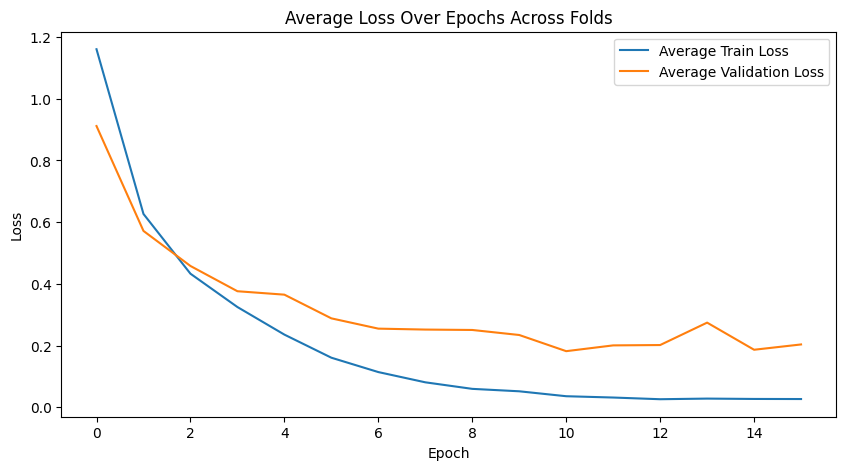

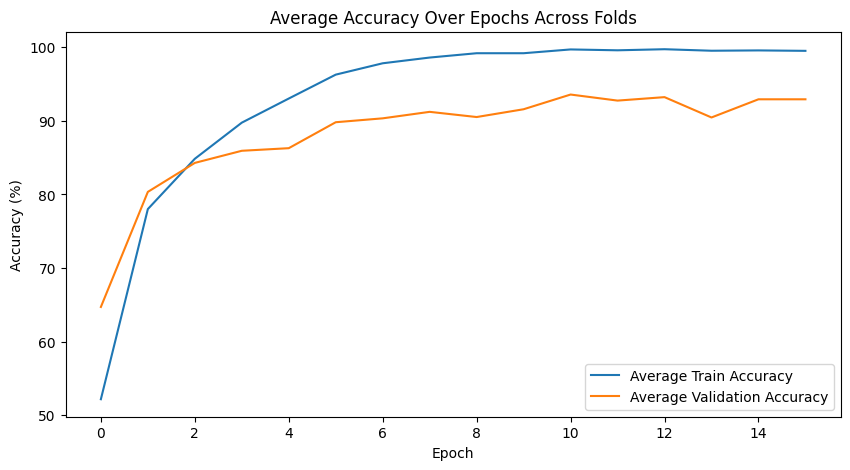

average_train_losses[1.16055861 0.62660493 0.43297009 0.3249361  0.23553669 0.16066675
 0.11410357 0.0809077  0.05968407 0.05179968 0.03582485 0.03157532
 0.02610038 0.02812592 0.02698585 0.02669232]
average_val_losses[0.91156977 0.57159971 0.45800615 0.37613025 0.36502482 0.28822244
 0.25489416 0.25186931 0.25056851 0.23427333 0.18186081 0.20059821
 0.2017125  0.27437184 0.18644139 0.20363732]
average_train_accuracies[52.16176471 78.01470588 84.85294118 89.76470588 93.04411765 96.29411765
 97.83823529 98.61764706 99.20588235 99.20588235 99.72058824 99.60294118
 99.75       99.54411765 99.58823529 99.52941176]
average_val_accuracies[64.70588235 80.35294118 84.29411765 85.94117647 86.29411765 89.82352941
 90.35294118 91.23529412 90.52941176 91.58823529 93.58823529 92.76470588
 93.23529412 90.47058824 92.94117647 92.94117647]


In [ ]:
# Calculate average metrics across folds
average_train_losses = np.mean(all_train_losses, axis=0)  # Average loss per epoch
average_val_losses = np.mean(all_val_losses, axis=0)
average_train_accuracies = np.mean(all_train_accuracies, axis=0)
average_val_accuracies = np.mean(all_val_accuracies, axis=0)

# Plot Average Loss
plt.figure(figsize=(10, 5))
plt.plot(average_train_losses, label="Average Train Loss")
plt.plot(average_val_losses, label="Average Validation Loss")
plt.title("Average Loss Over Epochs Across Folds")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Average Accuracy
plt.figure(figsize=(10, 5))
plt.plot(average_train_accuracies, label="Average Train Accuracy")
plt.plot(average_val_accuracies, label="Average Validation Accuracy")
plt.title("Average Accuracy Over Epochs Across Folds")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

print('average_train_losses' + str(average_train_losses))
print("average_val_losses" + str(average_val_losses))
print("average_train_accuracies" + str(average_train_accuracies))
print("average_val_accuracies" + str(average_val_accuracies))

In [ ]:
import warnings
def display_test_predictions(model, test_loader, class_names, num_images=16):

    model.eval()
    model = model.to(device)
    images_shown = 0
    correct_preds = 0
    total_preds = 0
    fig = plt.figure(figsize=(6, 6))

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break

                #Unnormalize the image
                img = images[i].cpu().numpy().transpose((1, 2, 0))
                img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

                ax = fig.add_subplot(int(np.sqrt(num_images)), int(np.sqrt(num_images)), images_shown + 1, xticks=[], yticks=[])
                ax.imshow(img)
                ax.set_title(f"True: {class_names[labels[i].item()]}\nPred: {class_names[preds[i].item()]}",
                             color=("green" if preds[i] == labels[i] else "red"))
                images_shown += 1

            if images_shown >= num_images:
                break

    accuracy = 100 * correct_preds / total_preds
    warnings.filterwarnings("ignore")

    plt.tight_layout()
    plt.show()
    print(f"Test Accuracy: {accuracy:.2f}%")



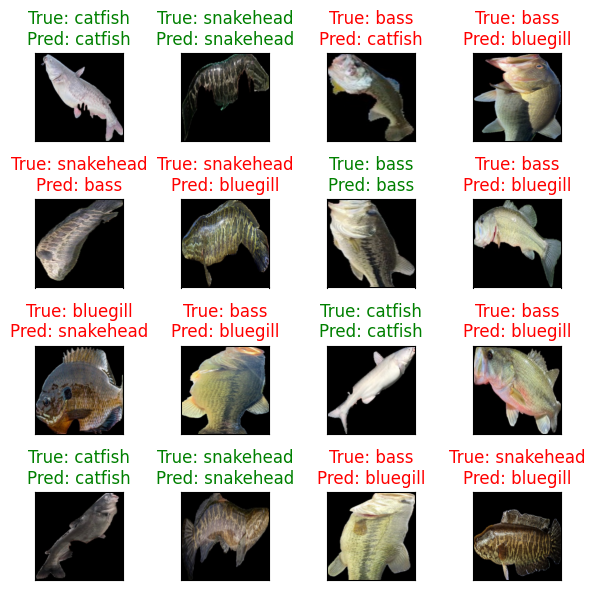

Test Accuracy: 53.12%


In [ ]:

# Display a sample of the test dataset, the correctness of the prediction and test accuracy
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

display_test_predictions(model, test_loader, class_names=['bass', 'bluegill', 'catfish', 'snakehead'])